# Experimentation Notebook using a UPS data set

#### Author: Larry Berk, PS AI Labs             Date: March 2021

PS data scientists have created an experimentation (A/B testing) tool from Bayesian inference principles. 
They experimented with pymc3 but deployed an analytic solution leveraging conjugate prior and posterior:

     -- the prior probability of conversion is p ~ Beta(a,b)
     -- the count of conversions (X) from N visitors is X ~ Binomial(N,p)
     -- consequently, the posterior probability is p ~ Beta(a + X, b + (N - X)), and
     -- the posterior predictive distribution is p(X_hat | X) = BetaBinomial(a + X, b + (N - X)) 
     
While common, the Binomial(N,p) likelihood is very restrictive; the *only* permissible space of posterior probabilities is at the fixed N. In other words, the posterior assumes that the experiment's intent was to end at precisely N trials (not N-1, not N + 1).

Advertising experiments are not typically conducted with this intent. Instead, the experiment is run for a period of time and *it just so happens* that N trials were observed. In the test data that follows, it is far more likely that daily counts of test and control visitors were happenstance, not explicitly targeted.

With the intent to conduct a daily experiment, this notebook posits that N is also a random variable.

    -- N ~ Poisson($\lambda$) with $\lambda$ considered an hourly visitation rate (in a 24 hour period)
    
Other suggestions are made throughout this notebook:

    -- an alternative specification of the Beta parameters 'a' and 'b' that may be more natural to the end user.
    -- a Bayesian model that works more directly with the reported quantities. This may alleviate some of the concerns about MCMC speed which can be accomplish in a few seconds. 

## Import the necessary libraries

pymc3 (https://docs.pymc.io/) is used for modeling and ArviZ (https://arviz-devs.github.io/) is used for visual diagnostics.

    -- This notebook will not explain much about pymc3 and arviz commands, leaving that to the respective user guides.
    

In [1]:
%matplotlib inline 

import pandas as pd 
import numpy as np
import pymc3 as pm
from scipy import stats

import matplotlib.pyplot as plt 
import arviz as az 

## The sample data set

Load test_data.csv to your appropriate local directory.

This view is the original, unaltered. It appears that an experiment was conducted daily for two calendar weeks including the July 4th holiday weekend. 

In [2]:
data = pd.read_csv('test_data.csv', skiprows=[0])
cols = ['day', 'visit_control', 'kpi_control', 'visit_test', 'kpi_test']
rname = dict(zip(data.columns, cols))
data = data.rename(columns=rname)
data

day  visit_control  kpi_control  visit_test  kpi_test
0   6/25/20          17946     0.812520       17491  0.808586
1   6/26/20          18826     0.719611       18571  0.717126
2   6/27/20           2617     0.787575        2673  0.802411
3   6/28/20           2302     0.831519        2101  0.802454
4   6/29/20          21511     0.769381       21666  0.768821
5   6/30/20          21950     0.783007       21831  0.779839
6    7/1/20          19744     0.786579       19697  0.794778
7    7/2/20          17229     0.798334       17055  0.791138
8    7/3/20           6467     0.806543        6584  0.811242
9    7/4/20           1148     0.826599        1023  0.780045
10   7/5/20           1772     0.844274        1770  0.837154
11   7/6/20          18490     0.805659       18252  0.818562
12   7/7/20          19152     0.799151       19045  0.804076

## A little data manipulation

   The 2020 calendar confirms what seems evident, that days with very low visit_ totals are weekends (or Friday July 3, a day off for many in the US.) The experiment was not halted on these days, so we treat these rows differently rather than discard them entirely.
   
     -- translate each date to a day of week
     -- label each date as a workday or a non-workday. Not usually trivial, but it is for this data set.
     -- derive counts of converting visitors...the counts behind the kpi_ proportions for control and test:
         -- converters = visitors * kpi (or, kpi = converters / visitors...p_hat = X / N in a Binomial process).

In [3]:
dow = lambda x: pd.to_datetime(x).dayofweek
data['dow'] = data['day'].apply(dow)

def isWorkday(df: pd.DataFrame) -> int:
    
    return 1 if (df['dow'] < 5) and (df['day'] != '7/3/20') else 0

data['is_workday'] = data.apply(isWorkday,axis=1)

def prod(df: pd.DataFrame, group: str = 'control') -> int:
    
    return round(df['_'.join(['visit',group])] * df['_'.join(['kpi',group])],0)

data['convert_control'] = data.apply(prod,axis=1,args=('control',))
data['convert_test'] = data.apply(prod,axis=1,args=('test',))

In [4]:
data

day  visit_control  kpi_control  visit_test  kpi_test  dow  \
0   6/25/20          17946     0.812520       17491  0.808586    3   
1   6/26/20          18826     0.719611       18571  0.717126    4   
2   6/27/20           2617     0.787575        2673  0.802411    5   
3   6/28/20           2302     0.831519        2101  0.802454    6   
4   6/29/20          21511     0.769381       21666  0.768821    0   
5   6/30/20          21950     0.783007       21831  0.779839    1   
6    7/1/20          19744     0.786579       19697  0.794778    2   
7    7/2/20          17229     0.798334       17055  0.791138    3   
8    7/3/20           6467     0.806543        6584  0.811242    4   
9    7/4/20           1148     0.826599        1023  0.780045    5   
10   7/5/20           1772     0.844274        1770  0.837154    6   
11   7/6/20          18490     0.805659       18252  0.818562    0   
12   7/7/20          19152     0.799151       19045  0.804076    1   

    is_workday  convert_control  convert_test  
0            1          14581.0       14143.0  
1            1          13547.0       13318.0  
2            0           2061.0        2145.0  
3            0           1914.0        1686.0  
4            1          16550.0       16657.0  
5            1          17187.0       17025.0  
6            1          15530.0       15655.0  
7            1          13754.0       13493.0  
8            0           5216.0        5341.0  
9            0            949.0         798.0  
10           0           1496.0        1482.0  
11           1          14897.0       14940.0  
12           1          15305.0       15314.0

### Reorganize the data 

In [5]:
# Separate the 'control' from the 'test', label each observation {0,1} then piece back together
dfctrl = data[['visit_control','convert_control','is_workday']]
dfctrl['is_test'] = 0 #these are control individuals
dfctrl.rename(columns={'visit_control':'visit','convert_control':'convert'},inplace=True) #with labels, shorten the headers

dftest = data[['visit_test','convert_test','is_workday']]
dftest['is_test'] = 1 #these are test individuals
dftest.rename(columns={'visit_test':'visit','convert_test':'convert'},inplace=True)

data2 = pd.concat([dfctrl,dftest],axis=0,ignore_index=True)
data2

<ipython-input-5-f8e0563d457f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfctrl['is_test'] = 0 #these are control individuals
C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-5-f8e0563d457f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

visit  convert  is_workday  is_test
0   17946  14581.0           1        0
1   18826  13547.0           1        0
2    2617   2061.0           0        0
3    2302   1914.0           0        0
4   21511  16550.0           1        0
5   21950  17187.0           1        0
6   19744  15530.0           1        0
7   17229  13754.0           1        0
8    6467   5216.0           0        0
9    1148    949.0           0        0
10   1772   1496.0           0        0
11  18490  14897.0           1        0
12  19152  15305.0           1        0
13  17491  14143.0           1        1
14  18571  13318.0           1        1
15   2673   2145.0           0        1
16   2101   1686.0           0        1
17  21666  16657.0           1        1
18  21831  17025.0           1        1
19  19697  15655.0           1        1
20  17055  13493.0           1        1
21   6584   5341.0           0        1
22   1023    798.0           0        1
23   1770   1482.0           0        1
24  18252  14940.0           1        1
25  19045  15314.0           1        1

#### A little Gamma distribution scratchpad -- unimportant

In [43]:
20000/24

833.3333333333334

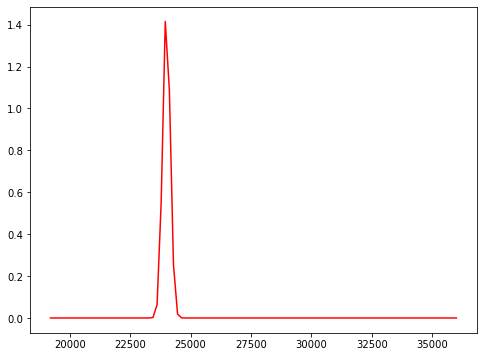

In [178]:
%matplotlib inline
from scipy import stats

a = 24000 # shape
b = 24 # rate = 1/scale

x = np.linspace(start=800, stop=1500, num=100)

plt.figure(figsize=(8, 6))
plt.plot(24*x, 24*stats.gamma.pdf(x,a=a,scale=1/b), 'r-')

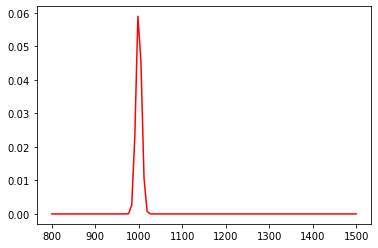

In [179]:
plt.plot(x, stats.gamma.pdf(x,a=a,scale=1/b), 'r-')

## *SKIP OVER*    A messy first attempt 

In [221]:
groups = data2['is_test'].values
workdays = data2['is_workday'].values
n_groups = len(set(group_idx))
n_dtypes = len(set(day_idx))

In [222]:
coords = {'Group':['Control','Test'],'Workday':['No','Yes'],'obs_id':np.arange(groups.size)}

In [180]:
import theano.tensor as tt

with pm.Model(coords=coords) as model:
    
    day_idx = pm.Data('day_idx',workdays,dims='obs_id')
    group_idx = pm.Data('group_idx',groups,dims='obs_id')
    
    omega = pm.Beta('omega',4., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)

    lamb = pm.Gamma('lambda',alpha=24000,beta=24,dims=('Group','Workday'))
    
    theta = pm.Beta('p',alpha=omega*(kappa-2)+1,beta=(1-omega)*(kappa-2)+1,dims=('Group','Workday'))
    
    n = pm.Poisson('N',mu=24*lamb,dims=('Group','Workday'))
    
    obs = data2['value'].values
    
#    obs = (obser.loc[idx[group_idx,day_idx]]['value'] - mu[group_idx,day_idx]) / np.sqrt(mu[group_idx,day_idx])
    
    y = pm.Binomial('y', p=theta[group_idx,day_idx], n=n[group_idx,day_idx], observed=obs, dims='obs_id')
    
    trace = pm.sample(5000, tune=1000, random_seed=123,chains=4,cores=4)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
    )
pm_data

C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, lambda, kappa_minus2, omega]
>Metropolis: [N]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 37 seconds.


0, dim: obs_id, 26 =? 26


There were 4124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6856489083676163, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4389 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4236 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3413 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: obs_id, 26 =? 26


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0, dim: obs_id, 26 =? 26
0, dim: obs_id, 26 =? 26


array([[<AxesSubplot:title={'center':'N'}>,
        <AxesSubplot:title={'center':'N'}>],
       [<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>],
       [<AxesSubplot:title={'center':'kappa_minus2'}>,
        <AxesSubplot:title={'center':'kappa_minus2'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>],
       [<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

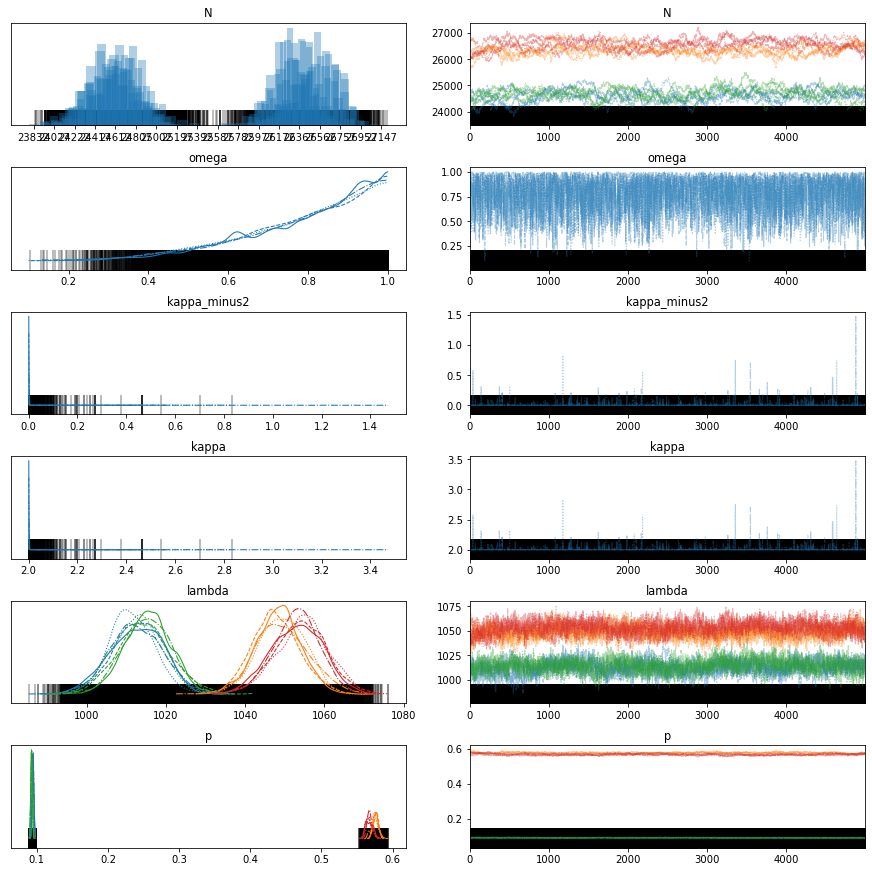

In [181]:
az.plot_trace(trace)

<AxesSubplot:xlabel='y'>

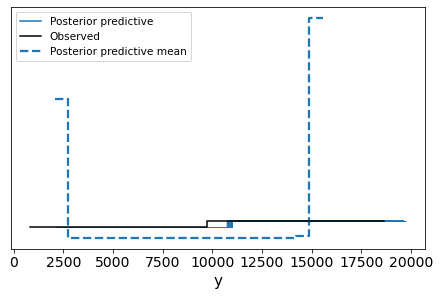

In [182]:
az.plot_ppc(pm_data,data_pairs={"y":"y"})

## *RESUME HERE* The first Bayesian model

### A visual representation of a hierarchical model

    -- day_idx and group_idx are pymc3 Data objects indexing each of the 26 data set observations as being 'control or test' or 'workday or non-workday'. This greatly simplifies data bookkeeping.
    -- the "y ~ Binomial" is the likelihood function (y ~ Binomial(N,p)). 
    -- p ~ Beta(a,b). The '2x2' means four (a,b) parameter pairs are derived from 2 'group' and 2 'day' dimensions
        -- an (a,b) pair for 'Control visitors on workdays'
        -- an (a,b) pair for 'Control visitors on non-workdays'
        -- an (a,b) pair for 'Test visitors on workdays'
        -- an (a,b) pair for 'Test visitors on non-workdays'
    -- the number of trials N is a Poisson($\lambda\$) random variable
    -- the $\lambda$ parameter has a Gamma(alpha,beta) prior.
    
This schematic describes a model to learn four sets of Beta(a,b) parameters: a pair for workdays and another pair for weekends. It is useful to see this initial attempt, but the best results come from running two models, one for workdays and the other for non-workdays. This 2x2 attempt did not perform adequately (very bad diagnostics) and it 'learned' the wrong weekend behavior. Instead of a high conversion rate with low visits, the single model learned a very low conversion rate (lower than any in the data) and a very high visitation count (higher than any in the data).
    
The next cell will construct this initial attempt strictly for purposes of drawing the diagram. No MCMC is run.

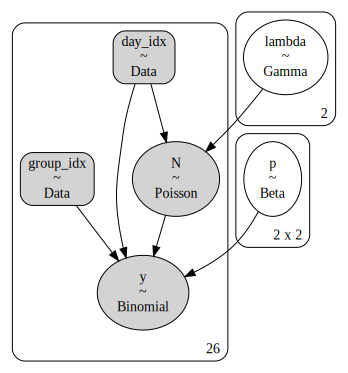

In [10]:
v_obs = data2['visit'].values # Array of visitor counts
x_obs = data2['convert'].values # Array of converter counts

groups = data2['is_test'].values
workdays = data2['is_workday'].values

coords = {'Group':['Control','Test'],'Workday':['No','Yes'],'obs_id':np.arange(groups.size)}

with pm.Model(coords=coords) as model: #construct the model with the given coords. 
    
    day_idx = pm.Data('day_idx',workdays,dims='obs_id') # Which observations are (non) workdays
    group_idx = pm.Data('group_idx',groups,dims='obs_id') # Each observation's experitmental group

    lamb = pm.Gamma('lambda',alpha=24000,beta=24,dims='Workday')
    
    theta = pm.Beta('p',alpha=9,beta=3,dims=('Group','Workday'))
    
    n = pm.Poisson('N',mu=24*lamb[day_idx],dims='obs_id',observed=v_obs)
    
#    obs = data2['value'].values
    
#    obs = (obser.loc[idx[group_idx,day_idx]]['value'] - mu[group_idx,day_idx]) / np.sqrt(mu[group_idx,day_idx])
    
    y = pm.Binomial('y', p=theta[group_idx,day_idx], n=n[day_idx], observed=x_obs, dims='obs_id')
    #y = pm.BetaBinomial('y',alpha=omega*(kappa-2)+1,beta=beta=(1-omega)*(kappa-2)+1, n=n[group_idx,day_idx], observed=x_obs, dims='obs_id')
    
#     trace = pm.sample(5000, tune=1000, random_seed=123,chains=4,cores=4)
#     prior = pm.sample_prior_predictive()
#     posterior_predictive = pm.sample_posterior_predictive(trace)
    
pm.model_to_graphviz(model)

### Set up parameters and indexes

#### pymc3 needs data from pandas in array format

In [11]:
groups = data2['is_test'].values
workdays = data2['is_workday'].values

#### A dictionary of 'coords' (dimensions for Bayesian inference)

    -- Specify two dimensions that Bayesian inference will be applied to:  
       -- experimental group (Control and Test)
    -- attach an index to each observation ('obs_id')

In [12]:
coords = {'Group':['Control','Test'],'obs_id':np.arange(v_obs.size)}

#### One way to specify Beta(a,b) parameters that may be more intuitive to end users

It is 'traditional' to specify the parameters a and b as related to occurrences of experiment and failure. A Beta(a=1,b=1) specification stipulates that 'successes are as common as failures', for a Beta(1,1) with a mean a/(a+b) = 1/2. Thus, 'on average', the success probability is that of a fair coin.

This formulation suggests and alternative for specifying the Beta prior for conversion probability p: 

    -- specify a prior *mode* ($\omega$)
    -- specify a degree of confidence you have in omega ($\kappa$)

The *mode* (the 'most likely' value of p) can be more intuitive to specify than the *mean* (of p). (Recall, Beta(a,b) is asymmetric, so mean <> mode.)

A nice interpretation of $\kappa$ (and the source of this suggestion) is Kruschke's book "Doing Bayesian Data Analysis, 2nd Edition". In fact, here it is verbatim:

"
The value we choose for the prior $\kappa$ can be thought of this way: It is the number of [experimental trials] that we would need to make us teeter between the new data and the prior belief about the prior mean ($\mu$ = a/a+b). If we would only need a few new [trials] to sway our beliefs, then our prior beliefs should be represented by a small $\kappa$ If we would need a large number of new [trials] to sway us away from our prior beliefs about µ, then our prior beliefs are
worth a very large $\kappa$
"


#### Conversion probabilities in the source data set clearly hover around 80%. 

So, set $\omega$ = 0.80.

#### There is (only) a two-week history of experimental trials.

Maybe this is a lot, maybe it is not. Arbitrarily, set $\kappa$ = 12. For me to sway away from the belief that 'conversion probability is 80%', I require '12 additional experimental trials'.

Apply the two formulae to convert ($\omega$, $\kappa$) into the traditional Beta(a,b) parameters. 
Omega = 0.8 and Kappa = 12 --> alpha = 9 and beta = 3. 

Mean = 9 / (9 + 3) = 0.75.  Remember, for a Beta distribution mean <> mode.

In [13]:
omega = 0.8 # mode of the prior for p
kappa = 12 # how many new trials necessary to trust posterior over prior

alpha = omega*(kappa-2)+1
beta = (1-omega)*(kappa-2)+1

### The 'workday' model implemented with pymc3

The model depicted by the schematic fit to data from workdays. (The p ~ Beta is not 2x2 but simply '2' for Control/Test.)

There is a few seconds pause for the infrastructure to get built, but once sampling starts, initialization and actual *all MCMC completes with 1 minute*.

MCMC samples from 4 chains using 4 CPUs. After the first 1000 'tuning' iterations, each chain is sampled another 5000 times.

The output is an ArviZ object that you can query (using the arrow buttons.)

In [72]:
#import theano.tensor as tt

# pymc3 needs pandas columns as arrays
groups = data2[data2['is_workday']==1]['is_test'].values 
v_obs = data2[data2['is_workday']==1]['visit'].values # daily visitations (N)
x_obs = data2[data2['is_workday']==1]['convert'].values #daily conversions (X)

coords = {'Group':['Control','Test'],'obs_id':np.arange(v_obs.size)}

with pm.Model(coords=coords) as model:
    
    group_idx = pm.Data('group_idx',groups,dims='obs_id') #Each observation's experimental group

    lamb = pm.Gamma('lambda',alpha=24000,beta=24,dims='Group') # A prior on hourly rate with mean = alpha/beta = 1000/hr
    
    theta = pm.Beta('p',alpha=alpha,beta=beta,dims='Group') # A prior for conversion probability
    
    n = pm.Poisson('N',mu=24*lamb[group_idx],dims='obs_id',observed=v_obs) # A prior for visitations
    
    y = pm.Binomial('y', p=theta[group_idx], n=n, observed=x_obs, dims='obs_id') #The likelihood function y ~ Binomial(N,p)
   
    # Include MCMC of the difference in test/control 'p'. Since the MCMC of the two theta chains (control and test)
    # completely determine values of the difference, this is a 'Deterministic' output.
    
    convert_diff = pm.Deterministic('diff_of_p', theta[1] - theta[0])
#    visit_diff = pm.Deterministic('diff_of_l', lamb[1] - lamb[0])
    
    trace = pm.sample(5000, tune=1000, random_seed=123,chains=4,cores=4) #Perform MCMC
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    # A wrapper object for ArviZ
    pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
    )
pm_data

C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, lambda]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


0, dim: obs_id, 16 =? 16
0, dim: obs_id, 16 =? 16


0, dim: obs_id, 16 =? 16
0, dim: obs_id, 16 =? 16


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

### Inference

Visualize the posteriors and modeling diagnostics. How to interpret them can be found in numerous tests and websites.

The trace plot (right hand panels) for this model suggest very good sampling.

C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0, dim: obs_id, 16 =? 16
0, dim: obs_id, 16 =? 16
0, dim: obs_id, 16 =? 16
0, dim: obs_id, 16 =? 16


C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:160: FutureWarning: chain_prop as a tuple will be deprecated in a future warning, use a dict instead
  warnings.warn(


array([[<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'diff_of_p'}>,
        <AxesSubplot:title={'center':'diff_of_p'}>]], dtype=object)

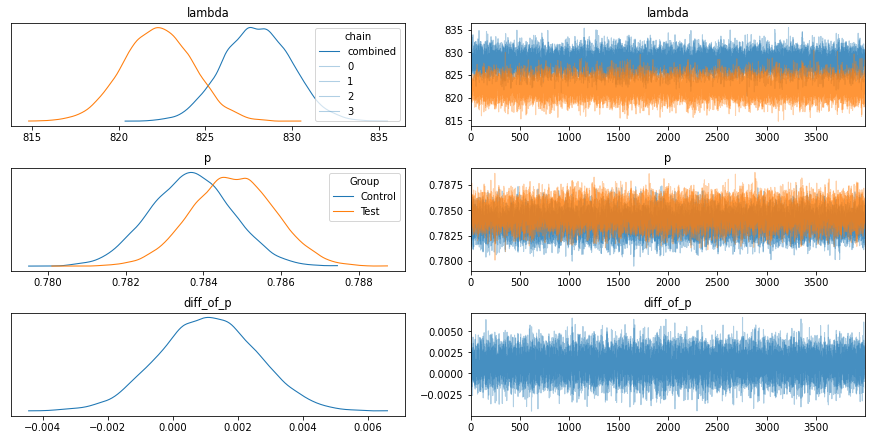

In [45]:
# Discard the first 1000 MCMC iterations as 'burn in'
az.plot_trace(trace[1000:], compact=True, combined=True, legend=True, chain_prop=("ls", "-"))

#### Plot posteriors for $\lambda$ and *p*. 

Notice the HDI defaults to 94%. Of course you can set to hdi_prob = 0.95. The default is a reminder that '95% confidence' is an arbitrary benchmark and that false alarm probabilities should be determined by the use case and not 'tradition'.

**First pair of curves:** The difference in (hourly) visitation rates between the two groups is (likely) insignificant, yet it is interesting how the control group rate skews slightly higher. This is borne out by the source data:

Average daily *workday* visits (Control) = **19356 > 19201** Average daily *workday* visits (Test)

**Second pair of curves:** There seems to be virtually no difference in conversation probabilities (p). We can explore this more directly with the posterior of the difference (next cells). If there is a higher test group 'p' it is a small fraction of 1%.

array([<AxesSubplot:title={'center':'lambda\nControl'}>,
       <AxesSubplot:title={'center':'lambda\nTest'}>,
       <AxesSubplot:title={'center':'p\nControl'}>,
       <AxesSubplot:title={'center':'p\nTest'}>], dtype=object)

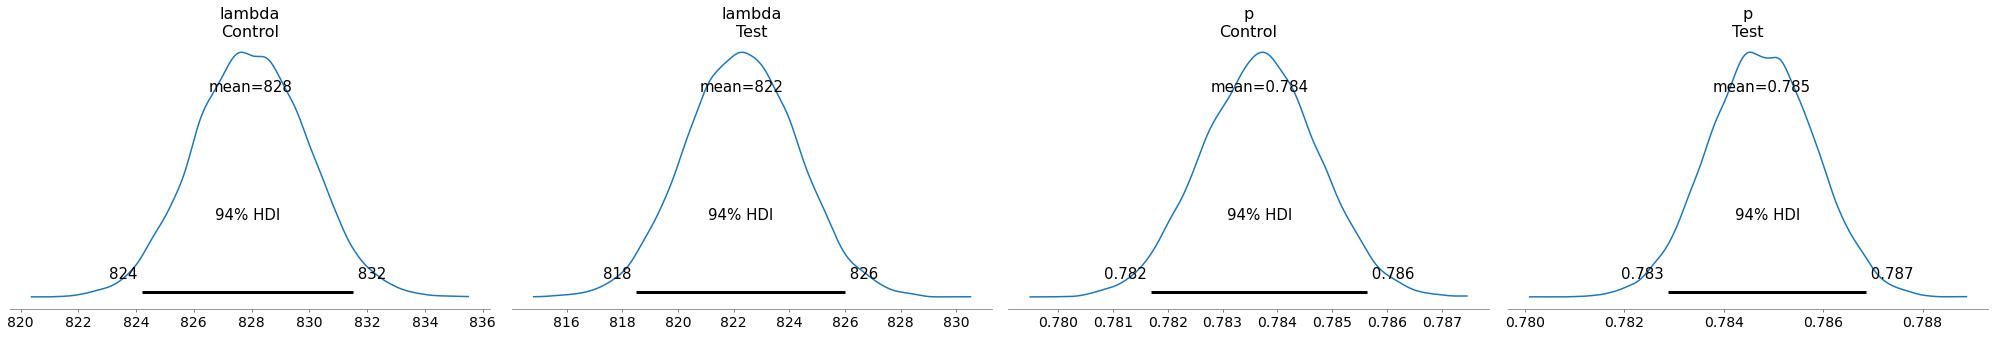

In [51]:
az.plot_posterior(pm_data['posterior'], var_names=['lambda','p'], round_to=3)

#### Plot the full posterior distribution for the difference in conversion probabilities (test minus control)

From the one pm.Deterministic() line within the pymc3 model block, we get this posterior without any extra work. We merely ask for the portion of the pm_data object with the key (name) we assigned to this difference.

This plot clearly confirms that there is no strong difference between test and control converion probabilities. Against a reference value of zero for the difference, the p-value large enough to conclude 'weak evidence that test group conversion is more likely than control group'. (Perhaps this experiment should be stopped.)

<AxesSubplot:title={'center':'diff_of_p'}>

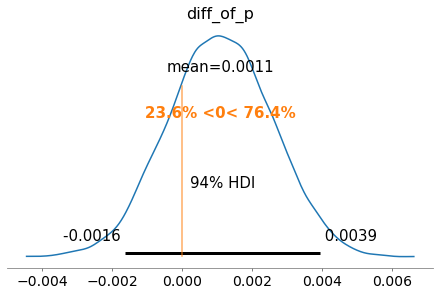

In [53]:
az.plot_posterior(pm_data['posterior'], var_names=['diff_of_p'], ref_val=0)

#### Posterior predictive checks for visitation counts (N) and conversion counts (y)

Limiting these checks to 200 MCMC samples so that the 'predictive mean' line shows thru, we can examine predictions of future N and y. Since N~Poisson and y~Binomial, the graphs are (correctly) discrete histograms.

The most likely predictions for N approx. 19800 is larger than the sample means from the data (19356 and 19201), but of course, this model purposely does not assume N~Normal. Likewise for predicted y.

array([<AxesSubplot:xlabel='N'>, <AxesSubplot:xlabel='y'>], dtype=object)

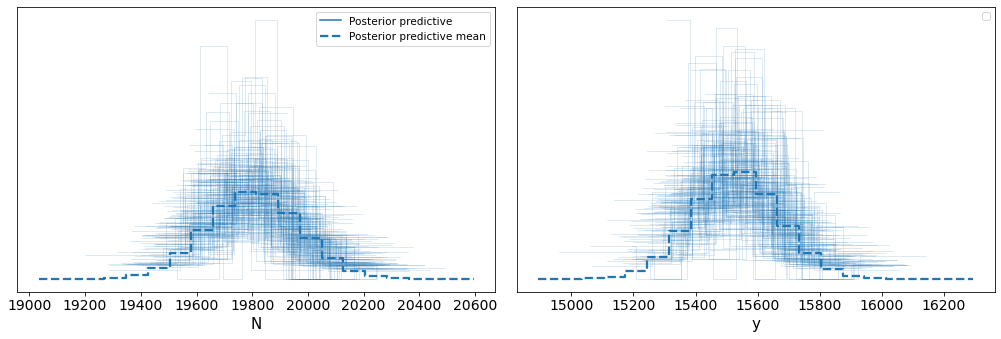

In [42]:
az.plot_ppc(pm_data, data_pairs={"y":"y"}, num_pp_samples=200, observed=False, random_seed=42)

#### Prior predictive checks for visitation counts (N) and conversion counts (y)

Limiting these checks to 200 MCMC samples so that the 'predictive mean' line shows thru, we can examine the suitability of our priors.

It is the same plot_ppc() function, merely with the group='prior' flag enabled. Overall, samples of the specified priors
seems reasonable. Prior sampling of 'N' is just what we expect, a distribution center around mean = 24000.

#### NOTE: Why requests for prior predictive plots for 'lambda' and 'p' do not work is perplexing.

<AxesSubplot:xlabel='N'>

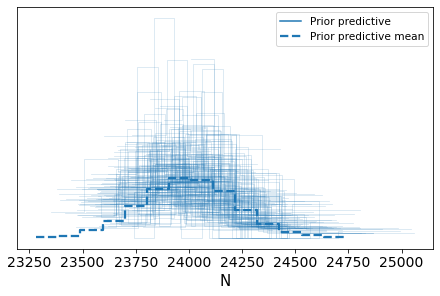

In [79]:
az.plot_ppc(pm_data, group='prior', var_names=['N'], num_pp_samples=200, observed=False, random_seed=42)

In [68]:
[l for l in enumerate(trace.varnames)]

[(0, 'lambda_log__'),
 (1, 'p_logodds__'),
 (2, 'lambda'),
 (3, 'p'),
 (4, 'diff_of_p'),
 (5, 'diff_of_l')]

### The 'non-workday' model implemented with pymc3

The model depicted by the schematic fit to data from non-workdays. (The p ~ Beta is not 2x2 but simply '2' for Control/Test.)

Since the only difference is the observations fed (is_workday = 0 rather than = 1), and a much lower prior estimate for hourly visits (100/hr) the next several cells have minimal commentary.

In [88]:
groups = data2[data2['is_workday']==0]['is_test'].values
v_obs = data2[data2['is_workday']==0]['visit'].values
x_obs = data2[data2['is_workday']==0]['convert'].values

coords = {'Group':['Control','Test'],'obs_id':np.arange(v_obs.size)}

with pm.Model(coords=coords) as model:
    
    group_idx = pm.Data('group_idx',groups,dims='obs_id')

    lamb = pm.Gamma('lambda',alpha=2400,beta=24,dims='Group')
    
    theta = pm.Beta('p',alpha=alpha,beta=beta,dims='Group')
    
    n = pm.Poisson('N',mu=24*lamb[group_idx],dims='obs_id',observed=v_obs)
    
    y = pm.Binomial('y', p=theta[group_idx], n=n, observed=x_obs, dims='obs_id')

    convert_diff = pm.Deterministic('diff_of_p', theta[1] - theta[0])
#    visit_diff = pm.Deterministic('diff_of_l', lamb[1] - lamb[0])

    trace = pm.sample(5000, tune=1000, random_seed=123,chains=4,cores=4) #Perform MCMC
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
    )
pm_data

C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, lambda]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


0, dim: obs_id, 10 =? 10
0, dim: obs_id, 10 =? 10


0, dim: obs_id, 10 =? 10
0, dim: obs_id, 10 =? 10


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

### Inference: Notice that the conversion posteriors 'flip' on non-workdays

Control hourly visitation rates are higher and so are conversion probabilities. Perhaps the former begets the latter. (More control group visitations might naturally lead to a higher chance of conversion among that group.

C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0, dim: obs_id, 10 =? 10
0, dim: obs_id, 10 =? 10
0, dim: obs_id, 10 =? 10
0, dim: obs_id, 10 =? 10


C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:160: FutureWarning: chain_prop as a tuple will be deprecated in a future warning, use a dict instead
  warnings.warn(


array([[<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'diff_of_p'}>,
        <AxesSubplot:title={'center':'diff_of_p'}>]], dtype=object)

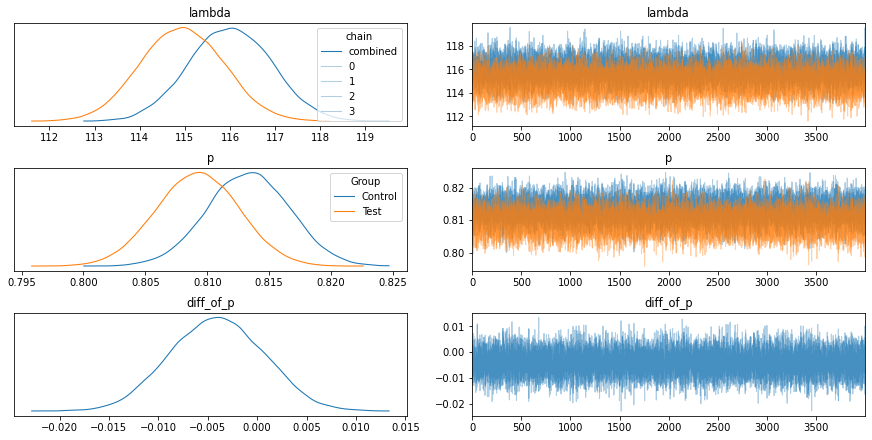

In [89]:
# Discard the first 1000 MCMC iterations as 'burn in'
az.plot_trace(trace[1000:], compact=True, combined=True, legend=True, chain_prop=("ls", "-"))

array([<AxesSubplot:title={'center':'lambda\nControl'}>,
       <AxesSubplot:title={'center':'lambda\nTest'}>,
       <AxesSubplot:title={'center':'p\nControl'}>,
       <AxesSubplot:title={'center':'p\nTest'}>], dtype=object)

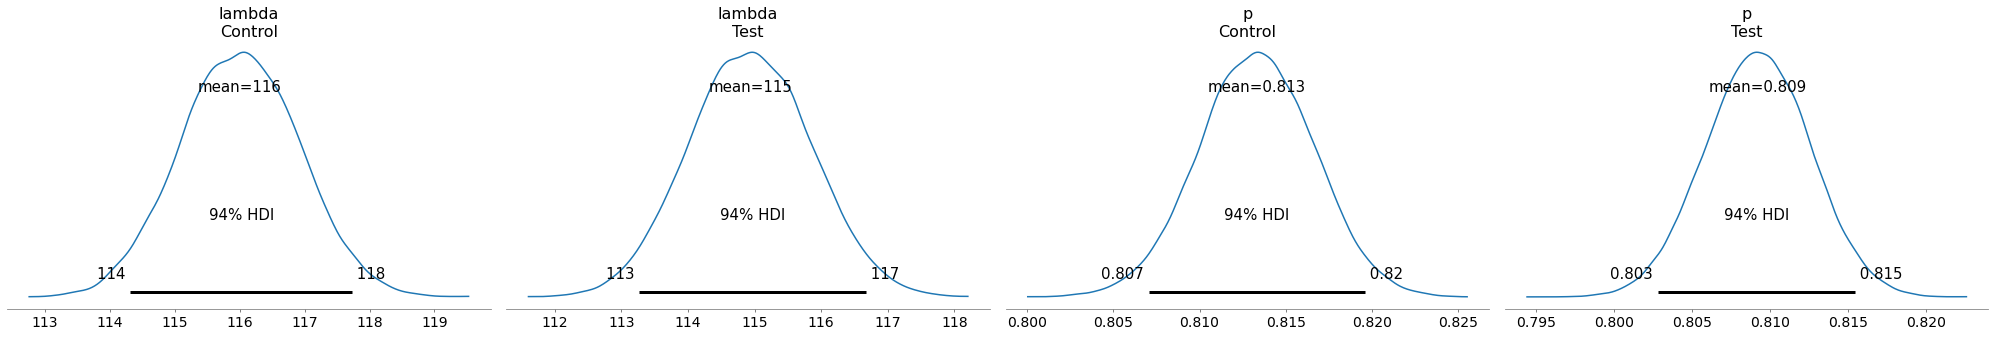

In [90]:
az.plot_posterior(pm_data['posterior'], var_names=['lambda','p'], round_to=3)

Even though the difference is (practically) of little consequence, the model predicts that Test group conversion is **lower than** Control group conversion on non-workdays. 

<AxesSubplot:title={'center':'diff_of_p'}>

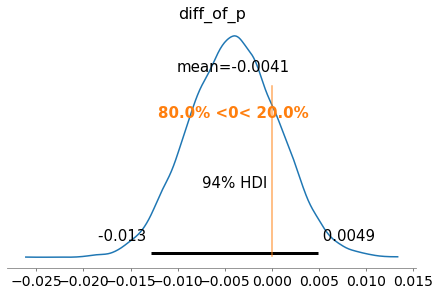

In [91]:
az.plot_posterior(pm_data['posterior'], var_names=['diff_of_p'], ref_val=0)

#### Posterior predictive checks for visitation counts (N) and conversion counts (y)

Limiting these checks to 200 MCMC samples so that the 'predictive mean' line shows thru, we can examine predictions of future N and y. Since N~Poisson and y~Binomial, the graphs are (correctly) discrete histograms.

The most likely predictions for N approx. 2800 very close to the sample mean for non-workday visitations (2845) from the data. But, that is largely driven by the July 3, 2020 data point.

array([<AxesSubplot:xlabel='N'>, <AxesSubplot:xlabel='y'>], dtype=object)

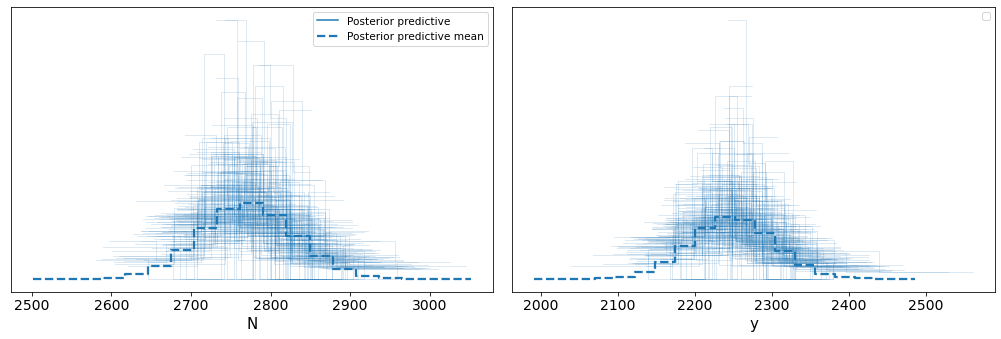

In [94]:
az.plot_ppc(pm_data, data_pairs={"y":"y"}, num_pp_samples=200, observed=False, random_seed=42)

#### Limiting these checks to 200 MCMC samples so that the 'predictive mean' line shows thru, we can examine the suitability of our priors.

It is the same plot_ppc() function, merely with the group='prior' flag enabled. Overall, samples of the specified priors
seems reasonable. Prior sampling of 'N' is just as expected, with a distribution centered around mean N = 2400.

<AxesSubplot:xlabel='N'>

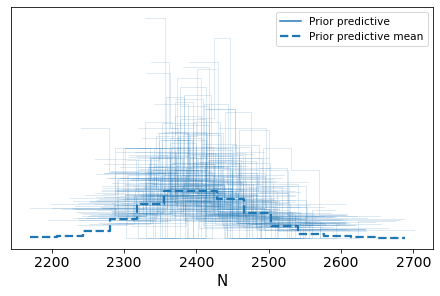

In [95]:
az.plot_ppc(pm_data, group='prior', var_names=['N'], num_pp_samples=200, observed=False, random_seed=42)

## What does this added complexity gain us?

Fit a simpler model without discriminating between workday/non-workday and without modeling visitations as N~Poisson.

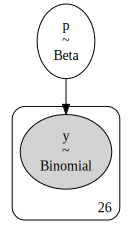

In [99]:
v_obs = data2['visit'].values # Array of visitor counts
x_obs = data2['convert'].values # Array of converter counts

with pm.Model() as model: #construct the model with the given coords. 
    
    theta = pm.Beta('p',alpha=1,beta=1)
    
    y = pm.Binomial('y', p=theta, n=v_obs, observed=x_obs)
    
#     trace = pm.sample(5000, tune=1000, random_seed=123,chains=4,cores=4)
#     prior = pm.sample_prior_predictive()
#     posterior_predictive = pm.sample_posterior_predictive(trace)
    
pm.model_to_graphviz(model)

In [102]:
groups = data2['is_test'].values
v_obs = data2['visit'].values
x_obs = data2['convert'].values

coords = {'Group':['Control','Test'],'obs_id':np.arange(v_obs.size)}

with pm.Model(coords=coords) as model:
    
    group_idx = pm.Data('group_idx',groups,dims='obs_id')

    theta = pm.Beta('p',alpha=alpha,beta=beta,dims='Group')
    
    y = pm.Binomial('y', p=theta[group_idx], n=v_obs, observed=x_obs, dims='obs_id')

    convert_diff = pm.Deterministic('diff_of_p', theta[1] - theta[0])
    
    trace = pm.sample(5000, tune=1000, random_seed=123,chains=4,cores=4)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
    )
pm_data

C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


0, dim: obs_id, 26 =? 26


0, dim: obs_id, 26 =? 26


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

### The simpler model is driven by workdays and non-workday behaviors are overlooked. A model simulating visitations is also not costly in terms of speed.

These results are effectively what the earlier 'workday' inference displays. 

Also, there was really no *cost* to a more correct N~Poisson($\lambda$) prior on a y~Binomial(N,p) likelihood. Sampling occurred just as rapidly with the extra hierarchy and we can develop insights about visitations regardless of conversion that we cannot with this simpler approach.

C:\Users\larry\anaconda3\envs\abtest\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0, dim: obs_id, 26 =? 26
0, dim: obs_id, 26 =? 26


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

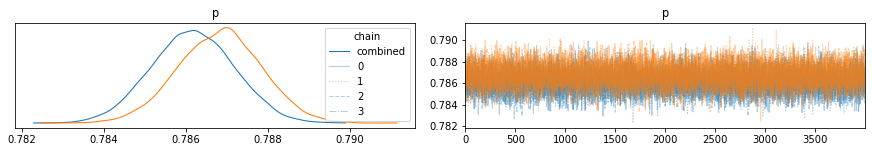

In [107]:
# Discard the first 1000 MCMC iterations as 'burn in'
az.plot_trace(trace[1000:], var_names=['p'], combined=True, legend=True)

The difference may have little practical significance, but notice that the simpler model predicts test group conversion is *less likely* than control group conversion. 

Here Prob(p[test] - p[control] > 0) = **67.4%**

Yet, since workdays are more frequent than non-workdays, the earlier model's insights are more useful:

Prob( *p_test - p_control* > 0) = **76.4% on workdays**

Prob( *p_test - p_control* > 0) = **20.0% on non-workdays**


<AxesSubplot:title={'center':'diff_of_p'}>

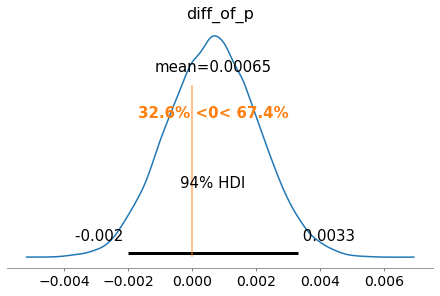

In [104]:
az.plot_posterior(pm_data['posterior'], var_names=['diff_of_p'], ref_val=0)